### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'wine',
    'source': 'kaggle',
    'remote_path': 'elvinrustam/wine-dataset',
    'files': ['WineDataset.csv'],
    'rename_files': ['wine.csv'],
    'task': 'reg',
    'target': 'Price',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/wine.
Downloaded wine dataset to /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/wine


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/wine/wine.csv


,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN


In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=0.6)
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['Secondary Grape Varieties'], dtype='object')
Dataframe shape before/afrer cleaning: (1290, 17) / (1290, 16)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = []

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")


Dataframe shape before/afrer by-hand cleaning: (1290, 16) / (1290, 16)


In [8]:
import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)

# Make the target column numeric
for df_file in dataset_files_cleaned:

    df_size = df_file.shape

    # print the first 3 rows of the Price column
    print("before: ", df_file['Price'].head(n=1))
    # remove the currency sign prefix
    # Step 1: Remove non-digit characters (like '?', ',')
    if df_file['Price'].dtype == 'object':
        # Check if the column is of type object
        # If so, remove non-digit characters
        df_file['Price'] = df_file['Price'].str.replace(r'[^\d]', '', regex=True)

    # Step 2: Convert the column to integers
    df_file['Price'] = pd.to_numeric(df_file['Price'])
    print("after: ", df_file['Price'].head(n=1))

    # remove rows with missing values in the Price column
    df_file.dropna(subset=['Price'], inplace=True)

    print(f"Dataframe shape before/after cleaning: {df_size} / {df_file.shape}")

# TODO: make the ABV column numeric, it is redundantly repeated and the same semantics can be gathered from the column name
# the column has strict ABV 13.50% -> make it 13.50
for df_file in dataset_files_cleaned:

    df_size = df_file.shape

    # print the first 3 rows of the Price column
    print("before:\n", df_file['ABV'].head(n=1))
    # remove the currency sign prefix
    # Step 1: Remove non-digit characters (like '?', ',')
    if df_file['ABV'].dtype == 'object':
        # Check if the column is of type object
        # If so, remove non-digit characters
        df_file['ABV'] = df_file['ABV'].str.replace(r'ABV\s*', '', regex=True).str.replace('%', '', regex=False)
        df_file['ABV'] = pd.to_numeric(df_file['ABV'], errors='coerce')


    # Step 2: Convert the column to integers
    df_file['ABV'] = pd.to_numeric(df_file['ABV'])
    print("after:\n", df_file['ABV'].head(n=1))

    # remove rows with missing values in the Price column
    df_file.dropna(subset=['ABV'], inplace=True)

    print(f"Dataframe shape before/after cleaning: {df_size} / {df_file.shape}")

# Make the vintage have None when not an integer
for df_file in dataset_files_cleaned:

    df_size = df_file.shape

    # print the first 3 rows of the Price column
    print("before:\n", df_file['Vintage'].head(n=1))
    # remove the currency sign prefix
    # Step 1: Remove non-digit characters (like '?', ',')
    if df_file['Vintage'].dtype == 'object':
        # Check if the column is of type object
        # If so, remove non-digit characters
        df_file['Vintage'] = df_file['Vintage'].str.replace(r'Vintage\s*', '', regex=True).str.replace('%', '', regex=False)
        df_file['Vintage'] = pd.to_numeric(df_file['Vintage'], errors='coerce')


    # Step 2: Convert the column to integers
    df_file['Vintage'] = pd.to_numeric(df_file['Vintage'])
    print("after:\n", df_file['Vintage'].head(n=1))

    print(f"Dataframe shape before/after cleaning: {df_size} / {df_file.shape}")

# dataset_files_cleaned = tmp_df
dataset_files_by_hand_cleaned = dataset_files_cleaned

before:  0    £9.99 per bottle
Name: Price, dtype: object
after:  0    999
Name: Price, dtype: int64
Dataframe shape before/after cleaning: (1290, 16) / (1290, 16)
before:
 0    ABV 14.00%
Name: ABV, dtype: object
after:
 0    14.0
Name: ABV, dtype: float64
Dataframe shape before/after cleaning: (1290, 16) / (1281, 16)
before:
 0    NV
Name: Vintage, dtype: object
after:
 0   NaN
Name: Vintage, dtype: float64
Dataframe shape before/after cleaning: (1281, 16) / (1281, 16)


### Now it is time to visualize our changes

In [9]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Title,Description,Price,Capacity,Grape,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,999,75CL,Tempranillo,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,14.0,NaN,Rich & Juicy,NaN,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,1599,75CL,Chardonnay,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,13.5,California,Rich & Toasty,2021.0,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,1249,75CL,Sauvignon Blanc,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,13.0,Marlborough,Crisp & Zesty,2022.0,NaN


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [10]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (3): ['Price', 'Capacity', 'Unit']
Categorical columns (7): ['Closure', 'Country', 'Per bottle / case / each', 'Type', 'ABV', 'Style', 'Vintage']
Textual columns (6): ['Title', 'Description', 'Grape', 'Characteristics', 'Region', 'Appellation']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [11]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,Title,"The Guv'nor, Spain",textual,1280
1,Description,We asked some of our most prized winemakers wo...,textual,1275
2,Price,999,numerical,~ 120 ~
3,Capacity,75CL,numerical,~ 12 ~
4,Grape,Tempranillo,textual,112
5,Closure,Natural Cork,categorical,4
6,Country,Spain,categorical,25
7,Unit,10.5,numerical,~ 55 ~
8,Characteristics,"Vanilla, Blackberry, Blackcurrant",textual,888
9,Per bottle / case / each,per bottle,categorical,2


In [12]:
# print capacitty unique values
df_file['Capacity'].unique()

array(['75CL', '70CL', '750ML', '1.5LTR', '37.5CL', '2.25L', '500ML',
       '50CL', '150CL', '300CL', '5LITRE', '375ML'], dtype=object)

In [13]:
# we need  to transform the capacity to a standardized format -> ML

cap_dict = {
    'ml': 1,
    'cl': 10,
    'dl': 100,
    'l': 1000,
    'litre': 1000,
    'ltr': 1000,
}

def standardize_capacity(value):
    # 1. extract the numeric part
    numeric_part = re.sub(r'[^0-9.]+', '', value)
    # 2. extract the unit part
    unit_part = re.sub(r'[0-9.]+', '', value)
    # 3. convert to lower case
    unit_part = unit_part.lower()
    # 4. convert to ml
    if unit_part in cap_dict:
        return float(numeric_part) * cap_dict[unit_part]
    else:
        print(f"Unknown unit: {unit_part}")
        return None
    
# Apply the function to the Capacity column
for df_file in dataset_files_by_hand_cleaned:
    if 'Capacity' in df_file.columns:
        def safe_standardize(val):
            if isinstance(val, str):
                return standardize_capacity(val)
            else:
                return val  # leave numbers, NaN untouched

        df_file['Capacity'] = df_file['Capacity'].apply(safe_standardize)


#### We also need to make sure that numerical columns are actually numerical :)

In [14]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


,Column Name,Example Value,Type,# Categories
0,Title,"The Guv'nor, Spain",textual,1280
1,Description,We asked some of our most prized winemakers wo...,textual,1275
2,Price,999.0,numerical,120
3,Capacity,750.0,numerical,8
4,Grape,Tempranillo,textual,112
5,Closure,Natural Cork,categorical,4
6,Country,Spain,categorical,25
7,Unit,10.5,numerical,55
8,Characteristics,"Vanilla, Blackberry, Blackcurrant",textual,888
9,Per bottle / case / each,per bottle,categorical,2


### Saving the processed data and loading it back up

In [15]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{file_base}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


Saved: /home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/../../datasets_files/raw/regression/wine/wine_processed.pkl


In [16]:
import os
import pandas as pd

# Loop through processed files in rename_files
for file_name in dataset_config['rename_files']:
    # Remove .csv or .tsv extension to get the base name
    file_base = os.path.splitext(file_name)[0]
    processed_filename = f"{file_base}_processed.pkl"
    processed_path = os.path.join(download_path, processed_filename)

    # Load the bundled dictionary (data + summary + config)
    bundle = pd.read_pickle(processed_path)

    # Extract components
    loaded_df = bundle['data']
    summary_df = bundle['summary']
    loaded_config = bundle['config']

    print(f"\n=== {file_base.upper()} ===")
    print(f"Loaded config keys: {list(loaded_config.keys())}")

    # Show metadata
    meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
    display(meta_df)

    # Flatten for modeling
    loaded_df.columns = loaded_df.columns.get_level_values(0)
    display(loaded_df.head(n=3))



=== WINE ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Title,textual,1280
1,Description,textual,1275
2,Price,numerical,120
3,Capacity,numerical,8
4,Grape,textual,112
5,Closure,categorical,4
6,Country,categorical,25
7,Unit,numerical,55
8,Characteristics,textual,888
9,Per bottle / case / each,categorical,2


Column Name,Title,Description,Price,Capacity,Grape,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,999.0,750.0,Tempranillo,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,14.0,NaN,Rich & Juicy,NaN,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,1599.0,750.0,Chardonnay,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,13.5,California,Rich & Toasty,2021.0,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,1249.0,750.0,Sauvignon Blanc,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,13.0,Marlborough,Crisp & Zesty,2022.0,NaN


### Bonus insights (Regression)

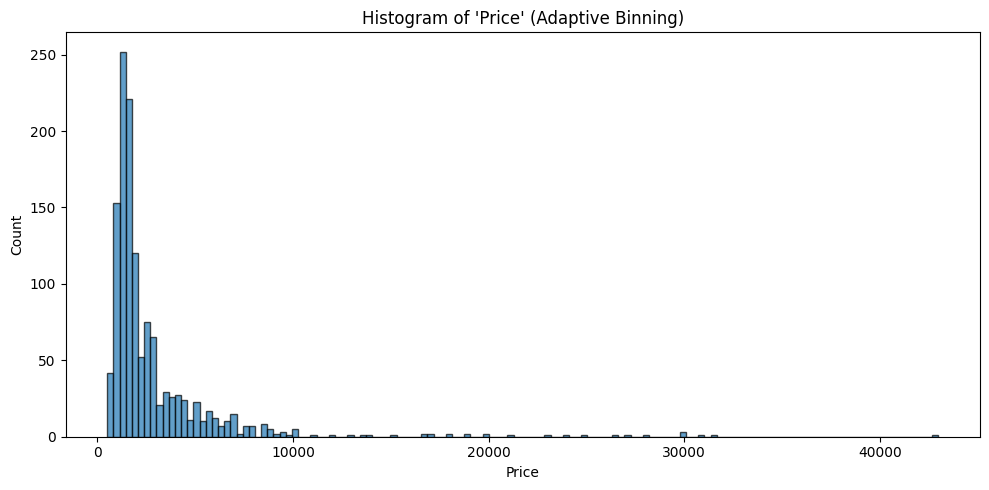

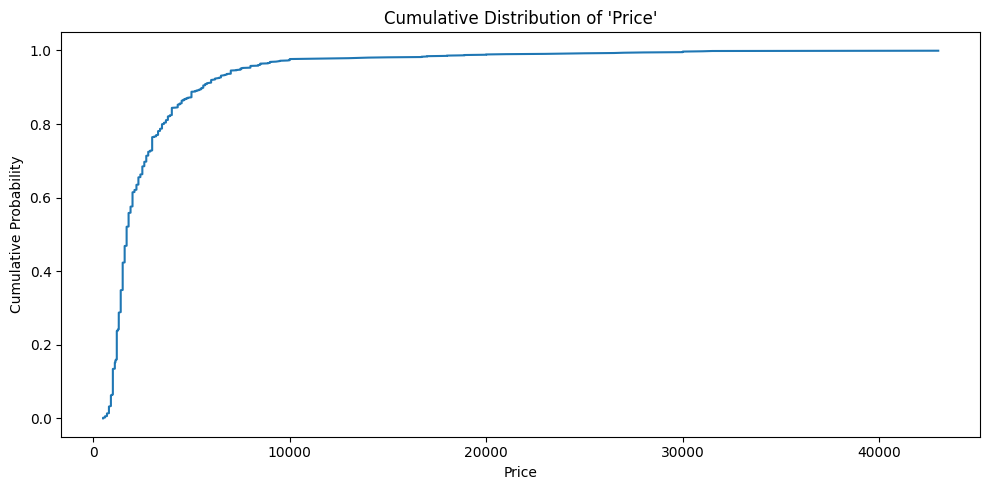

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']]

# 1️⃣ Histogram with Freedman-Diaconis rule for binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = int((target_series.max() - target_series.min()) / bin_width)
bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Cumulative Distribution Function (CDF)
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()



In [18]:
from baseline_eval import evaluate_baseline, plot_model_performance_summary
results = evaluate_baseline(
    df=loaded_df,
    model='AGTabular',
    df_name=dataset_config['dataset_name'],
    label_col= dataset_config['target'],
    task_type=dataset_config['task'],
    textual_cols=textual_cols,
    k_folds=5,
    seed=0,
    max_samples=3000,
    output_path=f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250521_160032"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #53~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jan 15 19:18:46 UTC 2
CPU Count:          64
Memory Avail:       313.25 GB / 503.54 GB (62.2%)
Disk Space Avail:   33796.64 GB / 51214.59 GB (66.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1



[WRAPPER] Running stratified downsampling mode for task: reg
Info: 
[INFO] Downsampling dataframe: wine (original rows: 1281)
Info: Dataset has only 1281 rows. No downsampling needed.
Downsampled 1281 rows for wine dataset.


Beginning AutoGluon training ... Time limit = 360s
AutoGluon will save models to "/home/guptaa/anshul/FreeText_TaBench/datasets_notebooks/regression/AutogluonModels/ag-20250521_160032"
Train Data Rows:    1024
Train Data Columns: 15
Label Column:       Price
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    320760.23 MB
	Train Data (Original)  Memory Usage: 1.92 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFe

In [19]:
rs = pd.read_csv(f"../../baseline_results/{dataset_config['task']}/{dataset_config['dataset_name']}.csv")
plot_model_performance_summary(name=dataset_config['dataset_name'],task=dataset_config['task'], df=rs)

Saving plot to ../../baseline_results/plots/reg/score
Saving plot to ../../baseline_results/plots/reg/loss
Saving plot to ../../baseline_results/plots/reg/roc_auc


{'score':                                     mean       std
 model                                             
 AutoGluon_Tabular_without_text  0.448415  0.054467
 AutoGluon_Tabular_with_text     0.460022  0.064030,
 'loss':                                        mean         std
 model                                                  
 AutoGluon_Tabular_with_text     2513.190497  724.707452
 AutoGluon_Tabular_without_text  2537.759167  712.132207,
 'roc_auc':                                 mean  std
 model                                    
 AutoGluon_Tabular_with_text      NaN  NaN
 AutoGluon_Tabular_without_text   NaN  NaN}